# HW2A: Alignment with IBM Model 1

In [1]:
# Some of the functions below require an older version of torchtext than the default one Kaggle gives you.
# IMPORTANT: Make sure that Internet is turned on!!! (Notebook options in the bar on the right)
# IMPORTANT: If you're not already using Kaggle, we STRONGLY recommend you switch to Kaggle for hw1b in particular,
# because copying our notebook will pin you to a Python version that lets you install the right version of torchtext.
# On Colab you will have to downgrade your Python to e.g., 3.7 to do the below pip install, which is a pain to do.
# !pip install torchtext==0.8.1
# exit()

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import matplotlib.pyplot as plt # graphs and figures
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from collections import Counter
from itertools import product
import tqdm.notebook
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data

We'll start out by using a toy dataset. Please see [these slides](https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf) for a more complete coverage of IBM Model 1, and feel free to check out Philipp Koehn's book _Statistical Machine Translation_.

In [2]:
aligned_data = [
    (["das", "haus"], ["the", "house"]),
    (["das", "buch"], ["the", "book"]),
    (["ein", "buch"], ["a", "book"]),
]

## Alignment Model

Fill in the code for IBM Model 1 below. A correct implementation should achieve perplexity 4096 on the first iteration and perplexity around 70 by the tenth iteration, for the toy dataset above. Note that we'll be grading you only on the generated `self.translation_probabilities`, so the probability and perplexity functions only exist for you to check the correctness of your own implementation. You may wish to comment them out during implementation and check that `self.translation_probabilities` looks reasonable instead.

In [77]:
import math
class IBMModel1:
    def __init__(self, data, num_iterations=10, epsilon=1.0, compute_perplexity=True):
        self.data = data # aligned corpus as shown above
        self.num_iterations = num_iterations # iterations of expectation-maximization
        self.epsilon = epsilon
        self.compute_perplexity = compute_perplexity

        # Preprocess bitext data:
        self.source_words, self.target_words = set(), set()
        for (source,target) in self.data:
            self.source_words.update(source)
            self.target_words.update(target)

        # Initialize uniform probabilities:
        self.translation_probs = {(s,t): 1.0/len(self.target_words)
                                  for s,t in product(self.source_words, self.target_words)}
    def e_step(self):
        # YOUR SOLUTION HERE
        # - Iterate over paired sentences in the data and compute:
        # - (1) counts, the number of times a source word is translated into a target word,
        #       weighted by alignment probabilities
        # - (2) total, the sum of counts over all possible target words
        # See slide 32 for more information: https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf
        # BEGIN SOLUTION
        count = {(f,e):0 for f,e in product(self.source_words, self.target_words)}
        total = {f:0 for f in self.source_words}
        s_total = {e:0 for e in self.target_words}
        for pair in self.data:
            f,e = pair
            
            for word_e in e:
                s_total[word_e] = 0
                for word_f in f:
                    s_total[word_e] += self.translation_probs[(word_f,word_e)]
            
            for word_e in e:
                for word_f in f:
                    count[(word_f,word_e)] += self.translation_probs[(word_f,word_e)] / s_total[word_e]
                    total[word_f] += self.translation_probs[(word_f,word_e)] / s_total[word_e]
        return count, total        
        
        # END SOLUTION

    def m_step(self, counts, total):
        # YOUR SOLUTION HERE
        # - Update self.translation_probs using counts and total
        # BEGIN SOLUTION
        for pair in self.data:
            f,e = pair
            for word_f in f:
                for word_e in e:
                    self.translation_probs[(word_f,word_e)] = counts[(word_f,word_e)] / total[word_f]
        # END SOLUTION

    def train(self):
        # Run EM for self.num_iterations:
        for idx in tqdm.tqdm(range(self.num_iterations)):
            if self.compute_perplexity:
                print("Iteration: {} | Perplexity: {}".format(idx, self.perplexity()))
            counts, total = self.e_step()
            self.m_step(counts, total)
        if self.compute_perplexity:
            print("Iteration: {} | Perplexity: {}".format(self.num_iterations, self.perplexity()))

    def probability(self, source, target):
        # YOUR SOLUTION HERE
        # - Use the normalization trick from lecture to efficiently compute probabilities
        # - We'll use self.epsilon here, which is defined in the initialization
        # BEGIN SOLUTION
        f, e = source, target
        norm_value =  self.epsilon / ((len(source)) ** len(target))
        ts = []
        for i in range(len(f)):
            temp = []
            for j in range(len(e)):
                temp.append(self.translation_probs[(f[i],e[j])])
            ts.append(sum(temp))
        p = np.prod(ts)
        return norm_value * p
        # END SOLUTION

    def perplexity(self):
        # YOUR SOLUTION HERE
        # - Iterate over each pair of sentences in the dataset
        # - Call self.probability and compute a sum in log space
        # - Feel free to comment this out while testing your initial model
        # BEGIN SOLUTION
        probas = []
        for pair in self.data:
            f,e = pair
            probas.append(self.probability(f,e))
        log_probas = np.log(probas)
        return math.exp(-sum(log_probas))
        # END SOLUTION

    def get_alignment(self, source, target):
        # YOUR SOLUTION HERE
        # - Find the best word alignment for a source, target pair
        # - Output a list of [(source_idx, target_idx)]
        #   For example: (["ein", "buch"], ["a", "book"])
        #   should have an alignment [(0,0), (1,1)]
        # BEGIN SOLUTION
        f, e = source, target
        alignments = []
        for i in range(len(f)):
            probas = [self.translation_probs[(f[i],e[j])] for j in range(len(e))]
            alignments.append((i,np.argmax(probas)))
        return alignments
        # END SOLUTION

ibm = IBMModel1(aligned_data)
ibm.train()
assert(ibm.get_alignment(["ein", "buch"], ["a", "book"]) == [(0, 0), (1, 1)])
with open("example_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:00<00:00, 3415.84it/s]

Iteration: 0 | Perplexity: 2.972493555307842e+16
Iteration: 1 | Perplexity: 1230942173140.2183
Iteration: 2 | Perplexity: 253075606657.23917
Iteration: 3 | Perplexity: 83549078272.73138
Iteration: 4 | Perplexity: 39111696263.913025
Iteration: 5 | Perplexity: 23411387121.01307
Iteration: 6 | Perplexity: 16505460737.137268
Iteration: 7 | Perplexity: 12956808546.441563
Iteration: 8 | Perplexity: 10920223352.456423
Iteration: 9 | Perplexity: 9653934299.540964
Iteration: 10 | Perplexity: 8818185140.532877


## Visualization and Analysis

Write code to visualize alignments and rerun the IBM model on a (very slightly larger) toy dataset:

100%|██████████| 10/10 [00:00<00:00, 1407.63it/s]


Iteration: 0 | Perplexity: 2.972493555307842e+16
Iteration: 1 | Perplexity: 1230942173140.2183
Iteration: 2 | Perplexity: 253075606657.23917
Iteration: 3 | Perplexity: 83549078272.73138
Iteration: 4 | Perplexity: 39111696263.913025
Iteration: 5 | Perplexity: 23411387121.01307
Iteration: 6 | Perplexity: 16505460737.137268
Iteration: 7 | Perplexity: 12956808546.441563
Iteration: 8 | Perplexity: 10920223352.456423
Iteration: 9 | Perplexity: 9653934299.540964
Iteration: 10 | Perplexity: 8818185140.532877
[(0, 3), (1, 2), (2, 0), (3, 1)]


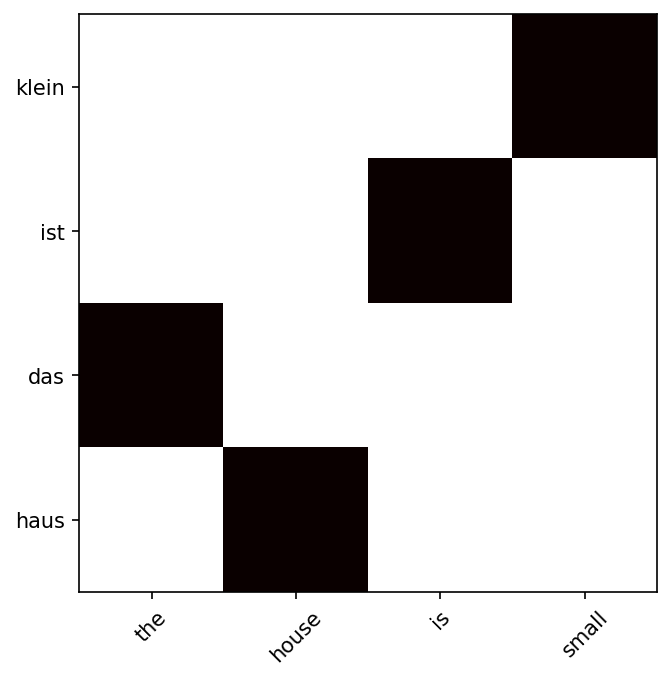

In [176]:
def visualize_alignment(alignment,f,e):
    # YOUR SOLUTION HERE
    # BEGIN ALIGNMENT
    print(alignment)
    matrix = np.zeros((len(alignment),len(alignment)))
    for index,item in enumerate(alignment):
        x, y = item
        matrix[index,y] = 1
    plt.figure(figsize=(5,5),dpi=150)
    plt.imshow(matrix, cmap=plt.cm.hot_r)
    plt.yticks(range(len(alignment)),f)
    plt.xticks(range(len(alignment)),e,rotation=45)
    plt.savefig(f'{hash(str(alignment))}.png')
    plt.show()
    # END ALIGNMENT
aligned_data = [
    (['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small']),
    (['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big']),
    (['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small']),
    (['das', 'haus'], ['the', 'house']),
    (['das', 'buch'], ['the', 'book']),
    (['ein', 'buch'], ['a', 'book'])
]

ibm = IBMModel1(aligned_data)
ibm.train()
alignment = ibm.get_alignment(['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])
visualize_alignment(alignment,['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])

We'll now run the IBM model on a significantly larger dataset to showcase its failure modes:


In [5]:
import sentencepiece
import torchtext
from torchtext.datasets import Multi30k

In [6]:
Multi30k.urls = [
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"
]

extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root="/kaggle/working/", test="test")

/opt/conda/envs/py37/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [177]:
def preprocess(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) # strip punctuation
    return sentence.strip().lower().split()

aligned_data = []
print(len(training_data))
for example in training_data[:1000]:
    source = preprocess(example.src)
    target = preprocess(example.trg)
    aligned_data.append((source, target))

ibm = IBMModel1(aligned_data, compute_perplexity=False)
ibm.train()
with open("multi30k_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

29000


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


('hund', 'dog'): 0.9765105915208369
('hund', 'cat'): 1.0745541756409012e-16
('ein', 'a'): 0.904016367677722
('ein', 'the'): 0.0002091328743299106
('frau', 'woman'): 0.9528437741343648
('frau', 'man'): 2.454275253390026e-07
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]


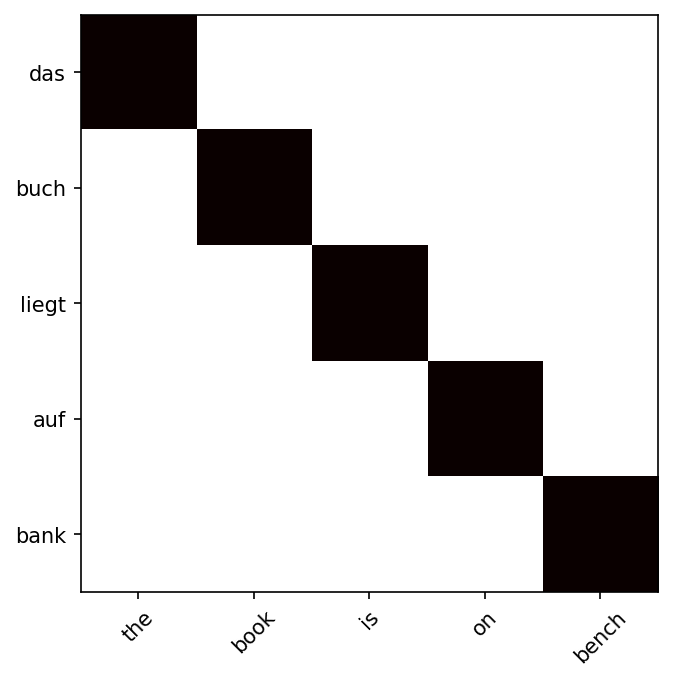

[(0, 5), (1, 1), (2, 1), (3, 1), (4, 4), (5, 6), (6, 5)]


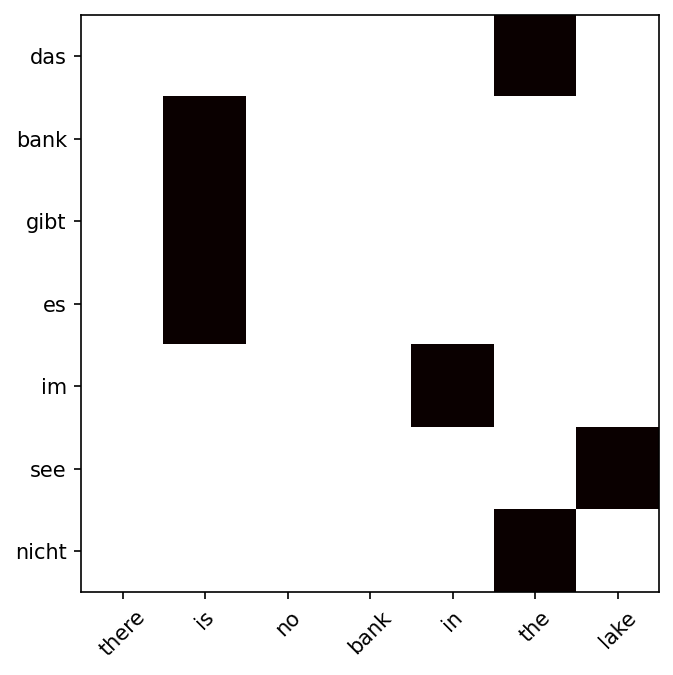

In [178]:
# Making sure the model learned something:
examples = [
    ("hund", "dog"),
    ("hund", "cat"),
    ("ein", "a"),
    ("ein", "the"),
    ("frau", "woman"),
    ("frau", "man"),
]
for example in examples:
    print(str(example) + ": " + str(ibm.translation_probs[example]))

index = 20
f = preprocess("Das Buch liegt auf Bank")
e = preprocess("the book is on bench")
alignment = ibm.get_alignment(f,e)
visualize_alignment(alignment,f,e)

f = preprocess("Das Bank gibt es im See nicht")
e = preprocess("There is no bank in the lake")
# print(f,e)
alignment = ibm.get_alignment(f,e)
visualize_alignment(alignment,f,e)

From this larger dataset: find at least one sentence where the IBM alignment model performs reasonably well, and find another one where it fails catastrophically, and include alignment visualizations for both examples in your report. You may want to consult a [German-English dictionary](https://www.collinsdictionary.com/us/dictionary/english-german) for this part of the problem. Provide a brief explanation for why the alignment model did poorly on the failure case.